In [1]:
import findspark
# $ cd /opt
# /opt$ sudo ln -s ~/apps/spark-3.4.0-bin-hadoop3 spark
findspark.init("/opt/spark") 

In [2]:
# import pyspark
# sc = pyspark.SparkContext(appName="globalContent")

# pg_jar = str(Path('~/apps/postgresql-42.5.4.jar').expanduser().resolve())
# bq_jar = str(Path('~/apps/spark-bigquery-with-dependencies_2.12-0.30.0.jar').expanduser().resolve())
# spark_jars = f"{pg_jar},{bq_jar}"

from pyspark.sql import SparkSession
# spark = SparkSession.builder \
#             .appName("LensFeatures") \
#             .config("spark.jars", spark_jars) \
#             .getOrCreate()
spark = SparkSession.builder \
            .appName("LensFeatures") \
            .getOrCreate()

23/05/22 09:32:22 WARN Utils: Your hostname, VIJAYs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.87.20 instead (on interface en0)
23/05/22 09:32:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/22 09:32:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# posts_df = spark.read.format('com.google.cloud.spark.bigquery') \
#                     .option('table','lens-public-data.polygon.public_profile_post') \
#                     .load()
posts_df = spark.read.csv("/tmp/lens_bigquery_csvs/public_profile_post/", 
                          header=True, 
                          escape="\"",
                          multiLine=True,
                          inferSchema=True)

In [4]:
# from pyspark.sql.functions import lit, current_timestamp, to_timestamp
# # ts = to_timestamp(lit('05-12-2023 00:00:00.000'),'MM-dd-yyyy HH:mm:ss.SSS')
# ts = current_timestamp()
# posts_df = posts_df \
#             .select("post_id") \
#             .withColumn("timestamp", ts)

from pyspark.sql.functions import col
posts_df = posts_df.select(
                        col("post_id").alias("posts"),
                        col("profile_id").alias("profiles"))

In [5]:
posts_df.printSchema()

root
 |-- posts: string (nullable = true)
 |-- profiles: string (nullable = true)



In [6]:
! gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=OTQvTBl3vcLSZtzFuFtbPWunqZtVI1&access_type=offline&code_challenge=P8XB6Bt1KwZdhUt8160BhGchXb-fJmWN7V16xB2z0tk&code_challenge_method=S256


Credentials saved to file: [/Users/vijay/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "boxwood-well-386122" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the

In [7]:
PROJECT_ID = "boxwood-well-386122"
REGION = "us-central1"
BUCKET_URI = "gs://vijay-lens-feature-store-temp"  
from google.cloud import aiplatform
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [8]:
FEATURESTORE_ID = "lens_featurestore_d2"
from google.cloud.aiplatform import Feature, Featurestore
fs = Featurestore(
    featurestore_name=FEATURESTORE_ID
)
print(fs.gca_resource)

name: "projects/1181216607/locations/us-central1/featurestores/lens_featurestore_d2"
create_time {
  seconds: 1684349445
  nanos: 286219000
}
update_time {
  seconds: 1684349445
  nanos: 525844000
}
etag: "AMEw9yNBceojpjzuQ2DYplH0sHRFEdQ8bMT0sQp9v7_09GKSnoxAPKwsR1WA1IdQswHc"
online_serving_config {
}
state: STABLE



In [9]:
FEATURES_IDS = {"posts": ["*"], "profiles": ["*"]}

In [10]:
INSTANCES_DF = posts_df.toPandas()

In [11]:
# google api expects a pandas Timestamp to be millisecond-aligned in RFC 3339 format 
# Example - 2012-07-30T10:43:17.123Z
import pandas as pd
from datetime import datetime
# ts = '2023-05-12T00:00:00.000Z' # hardcode to get features at a point in time
ts = datetime.utcnow().isoformat(sep='T', timespec='milliseconds')+'Z'
INSTANCES_DF['timestamp'] = pd.Timestamp(ts)

In [12]:
INSTANCES_DF.sample(10)

,posts,profiles,timestamp
326402,0x0123b5-0xc4,0x0123b5,2023-05-22 16:33:52.977000+00:00
275261,0x012186-0x45,0x012186,2023-05-22 16:33:52.977000+00:00
100814,0x01198f-0x03c2,0x01198f,2023-05-22 16:33:52.977000+00:00
38098,0x01151d-0x45,0x01151d,2023-05-22 16:33:52.977000+00:00
385953,0x01267b-0x2d,0x01267b,2023-05-22 16:33:52.977000+00:00
278475,0x012196-0x03d7,0x012196,2023-05-22 16:33:52.977000+00:00
281171,0x012196-0x0fa4,0x012196,2023-05-22 16:33:52.977000+00:00
6129,0x0113a8-0x0104,0x0113a8,2023-05-22 16:33:52.977000+00:00
441486,0x012943-0x41,0x012943,2023-05-22 16:33:52.977000+00:00
414079,0x0127d3-0x2d,0x0127d3,2023-05-22 16:33:52.977000+00:00


In [13]:
INSTANCES_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   posts      452441 non-null  object             
 1   profiles   452441 non-null  object             
 2   timestamp  452441 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 10.4+ MB


In [14]:
import datetime
from google.protobuf.timestamp_pb2 import Timestamp
# we had bad feature import on 5/11/2023, Let's ignore values before that date
bad_feature_time = datetime.datetime(year=2023, month=5, day=11, hour=0, minute=0, second=1)
START_TIME = Timestamp()
START_TIME.FromDatetime(bad_feature_time)
print(START_TIME)

seconds: 1683763201



In [15]:
# batch_serve_to_df(
#     serving_feature_ids: Dict[str, List[str]],
#     read_instances_df: pd.DataFrame,
#     pass_through_fields: Optional[List[str]] = None,
#     feature_destination_fields: Optional[Dict[str, str]] = None,
#     start_time: Optional[google.protobuf.timestamp_pb2.Timestamp] = None,
#     request_metadata: Optional[Sequence[Tuple[str, str]]] = (),
#     serve_request_timeout: Optional[float] = None,
#     bq_dataset_id: Optional[str] = None,
# )

features_df = fs.batch_serve_to_df(
    serving_feature_ids = FEATURES_IDS,
    read_instances_df = INSTANCES_DF,
    start_time = START_TIME,
)

Serving Featurestore feature values: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_d2


INFO:google.cloud.aiplatform.featurestore.featurestore:Serving Featurestore feature values: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_d2


Serve Featurestore feature values backing LRO: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_d2/operations/2141200145205690368


INFO:google.cloud.aiplatform.featurestore.featurestore:Serve Featurestore feature values backing LRO: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_d2/operations/2141200145205690368


Featurestore feature values served. Resource name: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_d2


INFO:google.cloud.aiplatform.featurestore.featurestore:Featurestore feature values served. Resource name: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_d2


In [16]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   main_content_focus               450923 non-null  object             
 3   comments                         452441 non-null  int64              
 4   language                         424234 non-null  object             
 5   recommend                        0 non-null       object             
 6   downvotes                        452441 non-null  int64              
 7   mirrors                          452441 non-null  int64              
 8   is_content_warning               452441 non-null  bool               
 9   custom_filters_gardener_flagged  452441 non-null  bool     

In [17]:
features_df['followship_rank'] = features_df['followship_rank'].astype('Int64')

In [18]:
features_df[features_df['entity_type_posts'].isin(['0x012258-0x73',
                                                   '0x012205-0x1e',
                                                   '0x011c8d-0x05'])]

,timestamp,entity_type_posts,main_content_focus,comments,language,recommend,downvotes,mirrors,is_content_warning,custom_filters_gardener_flagged,upvotes,age,region,is_original,profile_id,collects,content_warning,entity_type_profiles,followship_score,followship_rank
36218,2023-05-22 16:33:52.977000+00:00,0x012205-0x1e,IMAGE,0,en,None,0,0,False,False,0,186,None,False,0x012205,0,None,0x012205,4.650343e-07,19308
116939,2023-05-22 16:33:52.977000+00:00,0x012258-0x73,IMAGE,0,ru,None,0,0,False,False,0,13,None,True,0x012258,0,None,0x012258,2.206546e-07,31448
242201,2023-05-22 16:33:52.977000+00:00,0x011c8d-0x05,IMAGE,0,vi,None,0,0,False,False,1,57,None,False,0x011c8d,0,None,0x011c8d,1.433356e-07,41275


In [19]:
max_features = features_df \
                .groupby(["followship_rank"]) \
                .agg({'age': ['max'], 
                      'mirrors': ['max'], 
                      'collects': ['max'], 
                      'comments': ['max']})
max_features.columns = ['max_age', 'max_mirrors', 'max_collects', 'max_comments']

In [20]:
post_score_df = features_df.join(max_features, on='followship_rank', how='left')

In [21]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   main_content_focus               450923 non-null  object             
 3   comments                         452441 non-null  int64              
 4   language                         424234 non-null  object             
 5   recommend                        0 non-null       object             
 6   downvotes                        452441 non-null  int64              
 7   mirrors                          452441 non-null  int64              
 8   is_content_warning               452441 non-null  bool               
 9   custom_filters_gardener_flagged  452441 non-null  bool     

In [22]:
import pandas as pd
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns', 200)  
pd.set_option('display.float_format', '{:20,.20f}'.format)
post_score_df.sample(5)

,timestamp,entity_type_posts,main_content_focus,comments,language,recommend,downvotes,mirrors,is_content_warning,custom_filters_gardener_flagged,upvotes,age,region,is_original,profile_id,collects,content_warning,entity_type_profiles,followship_score,followship_rank,max_age,max_mirrors,max_collects,max_comments
443632,2023-05-22 16:33:52.977000+00:00,0x0113f0-0x9e,IMAGE,0,en,None,0,0,False,False,0,157,None,True,0x0113f0,0,None,0x0113f0,0.00000131862299906817,9588,229.00000000000000000000,9.00000000000000000000,3.00000000000000000000,3.00000000000000000000
111312,2023-05-22 16:33:52.977000+00:00,0x012241-0x02,TEXT_ONLY,0,en,None,0,0,False,False,0,211,None,False,0x012241,0,None,0x012241,0.00000006707300434725,68882,214.00000000000000000000,3.00000000000000000000,1.00000000000000000000,1.00000000000000000000
90847,2023-05-22 16:33:52.977000+00:00,0x012032-0x09-DA-f41ce988,TEXT_ONLY,0,None,None,0,0,False,False,1,10,None,True,0x012032,0,None,0x012032,0.00000005749516866697,76806,151.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
161451,2023-05-22 16:33:52.977000+00:00,0x011871-0x4a,VIDEO,0,tr,None,0,0,False,False,0,53,None,False,0x011871,0,None,0x011871,0.00000011818874212577,46337,213.00000000000000000000,10.00000000000000000000,8.00000000000000000000,1.00000000000000000000
95279,2023-05-22 16:33:52.977000+00:00,0x011b1b-0x61,TEXT_ONLY,0,tr,None,0,0,False,False,0,37,None,True,0x011b1b,0,None,0x011b1b,0.00000024352434714564,29538,213.00000000000000000000,10.00000000000000000000,8.00000000000000000000,1.00000000000000000000


In [23]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')  
pd.reset_option('display.float_format')

In [24]:
import numpy as np
post_score_df['max_mirrors'] = post_score_df['max_mirrors'].replace(0, np.nan)
post_score_df['max_collects'] = post_score_df['max_collects'].replace(0, np.nan)
post_score_df['max_comments'] = post_score_df['max_comments'].replace(0, np.nan)
post_score_df['max_age'] = post_score_df['max_age'].replace(0, np.nan)

In [25]:
# (1 * (mirrors_count::numeric / max_values.max_mirrors_count) +
# 1 * (collects_count::numeric / max_values.max_collects_count) +
# 3 * (comments_count::numeric / max_values.max_comments_count) -
# 5 * ((EXTRACT(EPOCH FROM (CURRENT_TIMESTAMP - block_timestamp))/(60*60*24)) / max_values.max_age_days)
# ) AS score

def calc_post_score(row):
    # avoid ZeroDivisionError
    return 1 * row['mirrors']/(row['max_mirrors'] if row['max_mirrors'] > 0 else 1e10) \
            + 1 * row['collects']/(row['max_collects'] if row['max_collects'] > 0 else 1e10) \
            + 3 * row['comments']/(row['max_comments'] if row['max_comments'] > 0 else 1e10) \
            - 5 * row['age']/(row['max_age'] if row['max_age'] > 0 else 1e10)

post_score_df['post_score'] = post_score_df.apply(calc_post_score, axis=1)

# post_score_df['post_score'] = post_score_df.apply(lambda row: (1 * row['mirrors']/row['max_mirrors'] \
#                                                             + 1 * row['collects']/row['max_collects'] \
#                                                             + 3 * row['comments']/row['max_comments'] \
#                                                             - 5 * row['age']/row['max_age']), 
#                                                   axis=1)

In [26]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   main_content_focus               450923 non-null  object             
 3   comments                         452441 non-null  int64              
 4   language                         424234 non-null  object             
 5   recommend                        0 non-null       object             
 6   downvotes                        452441 non-null  int64              
 7   mirrors                          452441 non-null  int64              
 8   is_content_warning               452441 non-null  bool               
 9   custom_filters_gardener_flagged  452441 non-null  bool     

In [27]:
# just making sure datatypes are correct
post_score_df['collects'] = post_score_df['collects'].astype('Int64')
post_score_df['custom_filters_gardener_flagged'] = post_score_df['custom_filters_gardener_flagged'].astype('bool')
post_score_df['upvotes'] = post_score_df['upvotes'].astype('Int64')
post_score_df['mirrors'] = post_score_df['mirrors'].astype('Int64')
post_score_df['is_original'] = post_score_df['is_original'].astype('bool')
post_score_df['is_content_warning'] = post_score_df['is_content_warning'].astype('bool')
post_score_df['age'] = post_score_df['age'].astype('Int64')
post_score_df['downvotes'] = post_score_df['downvotes'].astype('Int64')
post_score_df['comments'] = post_score_df['comments'].astype('Int64')
post_score_df['downvotes'] = post_score_df['downvotes'].astype('Int64')
post_score_df['max_age'] = post_score_df['max_age'].astype('Int64')
post_score_df['max_mirrors'] = post_score_df['max_mirrors'].astype('Int64')
post_score_df['max_collects'] = post_score_df['max_collects'].astype('Int64')
post_score_df['max_comments'] = post_score_df['max_comments'].astype('Int64')

In [33]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   main_content_focus               450923 non-null  object             
 3   comments                         452441 non-null  Int64              
 4   language                         424234 non-null  object             
 5   recommend                        0 non-null       object             
 6   downvotes                        452441 non-null  Int64              
 7   mirrors                          452441 non-null  Int64              
 8   is_content_warning               452441 non-null  bool               
 9   custom_filters_gardener_flagged  452441 non-null  bool     

In [29]:
import xgboost as xgb
model_filename = "20230522053757_model.json"
model_p = xgb.Booster()
model_p.load_model(model_filename)

In [31]:
import pickle
enc_filename = '20230522053757_recommend_encoder.pkl'
enc = pickle.load(open(enc_filename, 'rb'))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

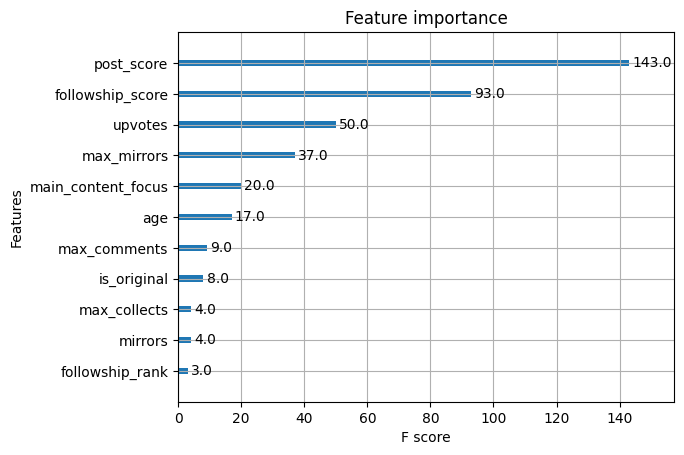

In [32]:
from xgboost import plot_importance
plot_importance(model_p)

In [48]:
model_p.feature_names

['region',
 'collects',
 'followship_score',
 'custom_filters_gardener_flagged',
 'upvotes',
 'content_warning',
 'mirrors',
 'is_original',
 'is_content_warning',
 'age',
 'followship_rank',
 'downvotes',
 'main_content_focus',
 'comments',
 'language',
 'max_age',
 'max_mirrors',
 'max_collects',
 'max_comments',
 'post_score']

In [55]:
input_df = post_score_df

In [56]:
model_excluded_fields = ['timestamp', 'entity_type_posts', 'profile_id', 'entity_type_profiles']

In [57]:
input_df, input_ex_df = input_df.drop(model_excluded_fields, axis=1), input_df[model_excluded_fields]

In [58]:
# recommend column values will be predicted. drop it from input.
input_df.drop('recommend', axis=1, inplace=True)

In [61]:
# order the columns in exactly the same order as they appear in the trained model
input_df = input_df[model_p.feature_names]

In [62]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   region                           362 non-null     object 
 1   collects                         452441 non-null  Int64  
 2   followship_score                 449934 non-null  float64
 3   custom_filters_gardener_flagged  452441 non-null  bool   
 4   upvotes                          452441 non-null  Int64  
 5   content_warning                  72 non-null      object 
 6   mirrors                          452441 non-null  Int64  
 7   is_original                      452441 non-null  bool   
 8   is_content_warning               452441 non-null  bool   
 9   age                              452441 non-null  Int64  
 10  followship_rank                  449934 non-null  Int64  
 11  downvotes                        452441 non-null  Int64  
 12  ma

In [63]:
input_ex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   timestamp             452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts     452441 non-null  object             
 2   profile_id            452441 non-null  object             
 3   entity_type_profiles  452441 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 13.8+ MB


In [64]:
cats = input_df.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    input_df[col] = input_df[col].astype('category')

In [65]:
dinput_df = xgb.DMatrix(input_df, enable_categorical=True)

In [66]:
predicted_y = model_p.predict(dinput_df)

In [67]:
len(predicted_y)

452441

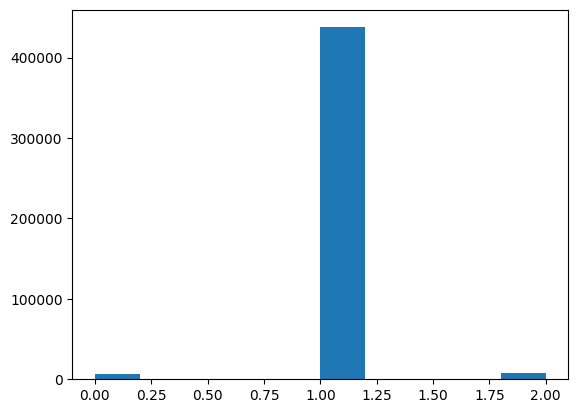

In [68]:
import matplotlib.pyplot as plt
plt.hist(predicted_y)
plt.show()

In [69]:
import numpy as np
predicted_y_int = np.rint(predicted_y)

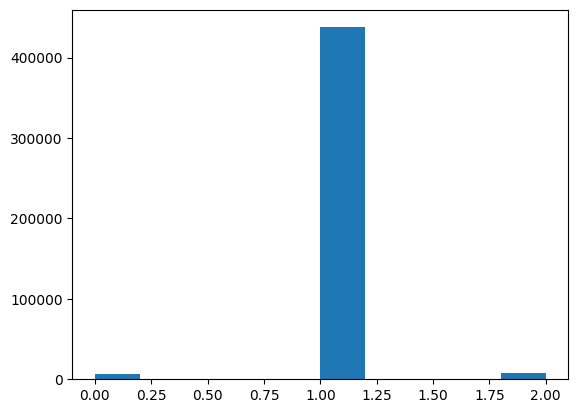

In [70]:
import matplotlib.pyplot as plt
plt.hist(predicted_y_int)
plt.show()

In [71]:
predicted_y_int

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [72]:
enc.categories_

[array(['MAYBE', 'NO', 'YES'], dtype=object)]

In [73]:
# sklearn encoder inverse_transform requires a 2D array
predicted_y_int = enc.inverse_transform(predicted_y_int.reshape(-1, 1))

In [74]:
# convert back from 2D array to 1D array so we can add column to Dataframe
predicted_y_int = predicted_y_int.reshape(-1)

In [75]:
predicted_y_int

array(['MAYBE', 'MAYBE', 'MAYBE', ..., 'NO', 'NO', 'NO'], dtype=object)

In [76]:
input_df['recommend'] = predicted_y_int

In [77]:
input_df['recommend'].value_counts()

recommend
NO       437656
YES        7968
MAYBE      6817
Name: count, dtype: int64

In [79]:
yes_fraction = round(80 / input_df['recommend'].value_counts()['YES'], 3)
print(yes_fraction)

maybe_fraction = round(20 / input_df['recommend'].value_counts()['MAYBE'], 3)
print(maybe_fraction)

0.01
0.003


In [80]:
# if there are NaN, converting pandas to pyspark fails with error
# can not merge type <class 'pyspark.sql.types.longtype'> and <class 'pyspark.sql.types.structtype'>
# followship_rank 0 does not make sense so let's set it to a very large value
# all other columns, set nan to 0
input_df['followship_rank'] = input_df['followship_rank'].fillna(1e10)
# can't fillna on categorical columns. so, get just the int columns
int_cols = input_df.select_dtypes(include=np.number).columns.tolist()
for col in int_cols:
    input_df.fillna(0)

In [81]:
import pandas as pd
output_df = pd.merge(input_df, input_ex_df, left_index=True, right_index=True)
output_df = output_df.rename(columns={'entity_type_posts': 'post_id'})

In [82]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   region                           362 non-null     category           
 1   collects                         452441 non-null  Int64              
 2   followship_score                 449934 non-null  float64            
 3   custom_filters_gardener_flagged  452441 non-null  category           
 4   upvotes                          452441 non-null  Int64              
 5   content_warning                  72 non-null      category           
 6   mirrors                          452441 non-null  Int64              
 7   is_original                      452441 non-null  category           
 8   is_content_warning               452441 non-null  category           
 9   age                              452441 non-null  Int64    

In [83]:
recommend_df = spark.createDataFrame(
                    output_df[['post_id', 'recommend',
                              'followship_rank', 'followship_score',
                              'post_score']])

In [84]:
posts_df = spark.read.csv("/tmp/lens_bigquery_csvs/public_profile_post/", 
                          header=True, 
                          escape="\"",
                          multiLine=True,
                          inferSchema=True)

In [85]:
# rename post_id column to avoid name conflict after join
recommend_df = recommend_df.withColumnRenamed('post_id', 'recommend_post_id')

posts_recommend_df = posts_df.join(recommend_df, posts_df.post_id == recommend_df.recommend_post_id, "leftouter")

In [86]:
recommendations = posts_recommend_df \
            .sampleBy('recommend', {'YES': yes_fraction, 'MAYBE': maybe_fraction}, 0)

In [87]:
recommendations.count()

23/05/22 10:09:11 WARN TaskSetManager: Stage 6 contains a task of very large size (4745 KiB). The maximum recommended task size is 1000 KiB.


94

In [88]:
recommendations.select(
    'post_id', 'language', 'content', 'recommend',
    'followship_rank', 'post_score',
    'custom_filters_gardener_flagged', 'main_content_focus').show(100, truncate = False)

23/05/22 10:09:25 WARN TaskSetManager: Stage 15 contains a task of very large size (4745 KiB). The maximum recommended task size is 1000 KiB.


+---------------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------